dependencies:
- NCBI datasets (https://www.ncbi.nlm.nih.gov/datasets/docs/v2/command-line-tools/download-and-install/)
- genbank_to (https://github.com/linsalrob/genbank_to)
- pyrodigal (https://github.com/althonos/pyrodigal)
- pyrodigal-rv (https://github.com/LanderDC/pyrodigal-rv) (clone and `pip install .`)

# Step 1: download *Riboviria* RefSeq genomes
NCBI `datasets` will download the genomes in fasta and the annotation report in json format.

In [ ]:
!mkdir refseq_genomes
%cd refseq_genomes
!datasets download virus genome taxon 2559587 --refseq --include genome,annotation --complete-only # "complete" is indicated by submitters so might not actually be complete

/bin/bash: line 0: cd: refseq_genomes: No such file or directory


Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: ncbi_dataset.zip    847B 1.32MB/s
Downloading: 

Unzip downloaded data

In [4]:
!unzip ncbi_dataset.zip -d refseq_data

Archive:  ncbi_dataset.zip
  inflating: refseq_data/README.md   
  inflating: refseq_data/ncbi_dataset/data/data_report.jsonl  
  inflating: refseq_data/ncbi_dataset/data/annotation_report.jsonl  
  inflating: refseq_data/ncbi_dataset/data/genomic.fna  
  inflating: refseq_data/ncbi_dataset/data/virus_dataset.md  
  inflating: refseq_data/ncbi_dataset/data/dataset_catalog.json  
  inflating: refseq_data/md5sum.txt  


Move files of interest and remove unzipped folder

In [ ]:
!mv refseq_data/ncbi_dataset/data/genomic.fna .
!mv refseq_data/ncbi_dataset/data/annotation_report.jsonl .
!rm -rf refseq_data

**Remove sequences that contain N's**:

In [ ]:
!seqkit grep -s -r -v -p "N" genomic.fna > genomic_no_N.fna

Reformat annotation json to tsv, select only fields of interest and add shorter header

In [12]:
!echo -e "accession\tstart\tstop\ttitle" > virus_annotations.tsv
!dataformat tsv virus-annotation --inputfile annotation_report.jsonl --fields accession,gene-cds-nuc-fasta-range-start,gene-cds-nuc-fasta-range-stop,gene-cds-nuc-fasta-title --elide-header >> virus_annotations.tsv

Also get RefSeq genbank file and convert to gff (more info is in this file, eg. translation table)

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/refseq/release/viral/viral.1.genomic.gbff.gz
!genbank_to --gff3 viral_refseq.gff -g viral.1.genomic.gbff
!grep -f <(grep '^>' genomic_no_N.fna |  sed 's/>//g' | cut -f 1 -d ' ') viral_refseq.gff > riboviria_refseq.gff

# Step 2: Predict genes with `pyrodigal-rv` 

In [ ]:
!pyrodigal-rv -i genomic_no_N.fna -o predictions_open.gff -j 5 
!pyrodigal-rv -i genomic_no_N.fna -o predictions_closed.gff -j 5 -c
!pyrodigal-rv -i genomic_no_N.fna -o predictions_open_start.gff -j 5 -c start

# Step 3: Evaluate performance

In [6]:
import re
from collections import defaultdict
import json
import os

def parse_ground_truth_gff(filename):
    """Parse ground truth GFF file and extract CDS features"""
    cds_features = {}
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            
            fields = line.strip().split('\t')
            if len(fields) < 9:
                continue
            
            seqid, source, feature_type, start, end, score, strand, phase, attributes = fields
            
            if feature_type == 'CDS':
                # Parse attributes
                attr_dict = {}
                for attr in attributes.split(';'):
                    if '=' in attr:
                        key, value = attr.split('=', 1)
                        attr_dict[key] = value
                
                # Get translation table (default is 1 if not specified)
                transl_table = int(attr_dict.get('transl_table', '1'))
                
                # Remove '<' or '>' from start/end positions (partial features)
                start_clean = start.lstrip('<').lstrip('>')
                end_clean = end.lstrip('<').lstrip('>')
                
                # Store CDS info
                key = seqid
                if key not in cds_features:
                    cds_features[key] = []
                
                cds_features[key].append({
                    'start': int(start_clean),
                    'end': int(end_clean),
                    'strand': strand,
                    'transl_table': transl_table,
                    'protein_id': attr_dict.get('protein_id', 'N/A')
                })
    
    return cds_features

def parse_prediction_gff(filename):
    """Parse prediction GFF file and extract CDS features"""
    cds_features = {}
    current_seqid = None
    current_transl_table = 1  # default
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('# Sequence Data:'):
                # Extract sequence ID
                match = re.search(r'seqhdr="([^"]+)"', line)
                if match:
                    current_seqid = match.group(1)
            
            elif line.startswith('# Model Data:'):
                # Extract translation table
                match = re.search(r'transl_table=(\d+)', line)
                if match:
                    current_transl_table = int(match.group(1))
            
            elif not line.startswith('#') and line.strip():
                fields = line.strip().split('\t')
                if len(fields) < 9:
                    continue
                
                seqid, source, feature_type, start, end, score, strand, phase, attributes = fields
                
                if feature_type == 'CDS':
                    # Remove '<' or '>' from start/end positions (partial features)
                    start_clean = start.lstrip('<').lstrip('>')
                    end_clean = end.lstrip('<').lstrip('>')
                    
                    # Store CDS info
                    key = seqid if current_seqid is None else current_seqid
                    if key not in cds_features:
                        cds_features[key] = []
                    
                    cds_features[key].append({
                        'start': int(start_clean),
                        'end': int(end_clean),
                        'strand': strand,
                        'transl_table': current_transl_table,
                        'attributes': attributes
                    })
    
    return cds_features

def deduplicate_list(lst, keys_to_check):
    """Remove duplicate dictionaries based on specified keys"""
    seen = set()
    unique_list = []
    
    for item in lst:
        # Create a tuple of values for the keys we want to check
        item_tuple = tuple(item.get(key) for key in keys_to_check)
        
        if item_tuple not in seen:
            seen.add(item_tuple)
            unique_list.append(item)
    
    return unique_list

def compare_predictions(ground_truth, predictions, source_name):
    """Compare ground truth and predictions"""
    results = {
        'exact_matches': [],
        'start_diff': [],
        'end_diff': [],
        'strand_diff': [],
        'transl_table_diff': [],
        'missing_in_prediction': [],
        'extra_in_prediction': []
    }
    
    # Only iterate over sequences that exist in ground truth
    for seqid in sorted(ground_truth.keys()):
        gt_cds_list = ground_truth[seqid]
        pred_cds_list = predictions.get(seqid, [])
        
        # Handle sequences with no predictions (only in ground truth)
        if not pred_cds_list:
            results['missing_in_prediction'].append({
                'seqid': seqid,
                'ground_truth': gt_cds_list,
                'source': source_name
            })
            continue
        
        # Track which predictions have been matched
        matched_predictions = set()
        
        # For each ground truth CDS, find best matching prediction
        for gt_cds in gt_cds_list:
            best_match = None
            best_match_idx = None
            best_score = 0
            
            for idx, pred_cds in enumerate(pred_cds_list):
                # Skip already matched predictions
                if idx in matched_predictions:
                    continue
                
                # Calculate similarity score
                score = 0
                if gt_cds['start'] == pred_cds['start']:
                    score += 1
                if gt_cds['end'] == pred_cds['end']:
                    score += 1
                if gt_cds['strand'] == pred_cds['strand']:
                    score += 1
                if gt_cds['transl_table'] == pred_cds['transl_table']:
                    score += 1
                
                if score > best_score:
                    best_score = score
                    best_match = pred_cds
                    best_match_idx = idx
            
            if best_match and best_score > 0:  # Only match if there's some similarity
                matched_predictions.add(best_match_idx)
                
                comparison = {
                    'seqid': seqid,
                    'gt_start': gt_cds['start'],
                    'pred_start': best_match['start'],
                    'gt_end': gt_cds['end'],
                    'pred_end': best_match['end'],
                    'gt_strand': gt_cds['strand'],
                    'pred_strand': best_match['strand'],
                    'gt_transl_table': gt_cds['transl_table'],
                    'pred_transl_table': best_match['transl_table'],
                    'source': source_name
                }
                
                if best_score == 4:  # All match
                    results['exact_matches'].append(comparison)
                else:
                    if gt_cds['start'] != best_match['start']:
                        results['start_diff'].append(comparison)
                    if gt_cds['end'] != best_match['end']:
                        results['end_diff'].append(comparison)
                    if gt_cds['strand'] != best_match['strand']:
                        results['strand_diff'].append(comparison)
                    if gt_cds['transl_table'] != best_match['transl_table']:
                        results['transl_table_diff'].append(comparison)
            else:
                # No match found for this ground truth CDS
                results['missing_in_prediction'].append({
                    'seqid': seqid,
                    'ground_truth': [gt_cds],
                    'source': source_name
                })
        
        # Add any unmatched predictions as extra
        for idx, pred_cds in enumerate(pred_cds_list):
            if idx not in matched_predictions:
                results['extra_in_prediction'].append({
                    'seqid': seqid,
                    'predictions': [pred_cds],
                    'source': source_name
                })
    
    return results

def merge_results(all_results):
    """Merge results from multiple prediction files"""
    merged = {
        'exact_matches': [],
        'start_diff': [],
        'end_diff': [],
        'strand_diff': [],
        'transl_table_diff': [],
        'missing_in_prediction': [],
        'extra_in_prediction': []
    }
    
    for results in all_results.values():
        for key in merged.keys():
            merged[key].extend(results[key])
    
    return merged

def print_results(all_results, output_file=None):
    """Print comparison results to console and optionally to file"""
    output_lines = []
    
    def add_line(line=""):
        print(line)
        output_lines.append(line)
    
    add_line("=" * 80)
    add_line("COMPARISON RESULTS - MULTIPLE PREDICTION FILES")
    add_line("=" * 80)
    
    # Print results for each prediction file
    for source_name, results in all_results.items():
        add_line(f"\n{'=' * 80}")
        add_line(f"RESULTS FOR: {source_name}")
        add_line(f"{'=' * 80}")
        
        # Deduplicate for display and file output
        comparison_keys = ['seqid', 'gt_start', 'pred_start', 'gt_end', 'pred_end', 
                          'gt_strand', 'pred_strand', 'gt_transl_table', 'pred_transl_table', 'source']
        
        exact_matches_unique = deduplicate_list(results['exact_matches'], comparison_keys)
        start_diff_unique = deduplicate_list(results['start_diff'], comparison_keys)
        end_diff_unique = deduplicate_list(results['end_diff'], comparison_keys)
        strand_diff_unique = deduplicate_list(results['strand_diff'], comparison_keys)
        transl_table_diff_unique = deduplicate_list(results['transl_table_diff'], comparison_keys)
        
        add_line(f"\nExact Matches: {len(exact_matches_unique)}")
        for match in exact_matches_unique[:10]:  # Show first 10
            add_line(f"  {match['seqid']}: start={match['gt_start']}, end={match['gt_end']}, "
                    f"strand={match['gt_strand']}, transl_table={match['gt_transl_table']}")
        if len(exact_matches_unique) > 10:
            add_line(f"  ... and {len(exact_matches_unique) - 10} more")
        
        add_line(f"\nStart Position Differences: {len(start_diff_unique)}")
        for diff in start_diff_unique[:10]:
            add_line(f"  {diff['seqid']}: GT={diff['gt_start']}, Pred={diff['pred_start']} "
                    f"(diff={diff['pred_start'] - diff['gt_start']})")
        if len(start_diff_unique) > 10:
            add_line(f"  ... and {len(start_diff_unique) - 10} more")
        
        add_line(f"\nEnd Position Differences: {len(end_diff_unique)}")
        for diff in end_diff_unique[:10]:
            add_line(f"  {diff['seqid']}: GT={diff['gt_end']}, Pred={diff['pred_end']} "
                    f"(diff={diff['pred_end'] - diff['gt_end']})")
        if len(end_diff_unique) > 10:
            add_line(f"  ... and {len(end_diff_unique) - 10} more")
        
        add_line(f"\nStrand Differences: {len(strand_diff_unique)}")
        add_line(f"Translation Table Differences: {len(transl_table_diff_unique)}")
        add_line(f"Missing in Predictions: {len(results['missing_in_prediction'])}")
        add_line(f"Extra in Predictions: {len(results['extra_in_prediction'])}")
        
        # Summary statistics for this file
        total_comparisons = (len(exact_matches_unique) + 
                            len(start_diff_unique) + 
                            len(end_diff_unique))
        
        if total_comparisons > 0:
            accuracy = len(exact_matches_unique) / total_comparisons * 100
            add_line(f"\nAccuracy for {source_name}: {accuracy:.2f}% "
                    f"({len(exact_matches_unique)}/{total_comparisons})")
    
    # Overall summary
    add_line(f"\n{'=' * 80}")
    add_line("OVERALL SUMMARY")
    add_line(f"{'=' * 80}")
    
    merged = merge_results(all_results)
    
    # Deduplicate merged results
    comparison_keys = ['seqid', 'gt_start', 'pred_start', 'gt_end', 'pred_end', 
                      'gt_strand', 'pred_strand', 'gt_transl_table', 'pred_transl_table', 'source']
    
    exact_matches_unique = deduplicate_list(merged['exact_matches'], comparison_keys)
    start_diff_unique = deduplicate_list(merged['start_diff'], comparison_keys)
    end_diff_unique = deduplicate_list(merged['end_diff'], comparison_keys)
    
    total_comparisons = (len(exact_matches_unique) + 
                        len(start_diff_unique) + 
                        len(end_diff_unique))
    
    if total_comparisons > 0:
        accuracy = len(exact_matches_unique) / total_comparisons * 100
        add_line(f"Total Exact Matches: {len(exact_matches_unique)}")
        add_line(f"Total Comparisons: {total_comparisons}")
        add_line(f"Overall Accuracy: {accuracy:.2f}%")
    
    # Write to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write('\n'.join(output_lines))
        print(f"\nResults saved to: {output_file}")

def save_results_tsv(all_results, output_file):
    """Save detailed comparison results to TSV file with source column"""
    with open(output_file, 'w') as f:
        # Write header
        f.write("source\tseqid\tstatus\tgt_start\tpred_start\tstart_diff\tgt_end\tpred_end\t"
                "end_diff\tgt_strand\tpred_strand\tgt_transl_table\tpred_transl_table\n")
        
        all_rows = []
        
        # Process each prediction file's results
        for source_name, results in all_results.items():
            # Collect exact matches
            for match in results['exact_matches']:
                all_rows.append({
                    'source': source_name,
                    'seqid': match['seqid'],
                    'status': 'exact_match',
                    'gt_start': match['gt_start'],
                    'pred_start': match['pred_start'],
                    'start_diff': 0,
                    'gt_end': match['gt_end'],
                    'pred_end': match['pred_end'],
                    'end_diff': 0,
                    'gt_strand': match['gt_strand'],
                    'pred_strand': match['pred_strand'],
                    'gt_transl_table': match['gt_transl_table'],
                    'pred_transl_table': match['pred_transl_table']
                })
            
            # Collect all differences
            all_diffs = (results['start_diff'] + results['end_diff'] + 
                        results['strand_diff'] + results['transl_table_diff'])
            
            for diff in all_diffs:
                start_diff = diff['pred_start'] - diff['gt_start']
                end_diff = diff['pred_end'] - diff['gt_end']
                status_parts = []
                if diff['gt_start'] != diff['pred_start']:
                    status_parts.append('start_diff')
                if diff['gt_end'] != diff['pred_end']:
                    status_parts.append('end_diff')
                if diff['gt_strand'] != diff['pred_strand']:
                    status_parts.append('strand_diff')
                if diff['gt_transl_table'] != diff['pred_transl_table']:
                    status_parts.append('transl_table_diff')
                status = '|'.join(status_parts)
                
                all_rows.append({
                    'source': source_name,
                    'seqid': diff['seqid'],
                    'status': status,
                    'gt_start': diff['gt_start'],
                    'pred_start': diff['pred_start'],
                    'start_diff': start_diff,
                    'gt_end': diff['gt_end'],
                    'pred_end': diff['pred_end'],
                    'end_diff': end_diff,
                    'gt_strand': diff['gt_strand'],
                    'pred_strand': diff['pred_strand'],
                    'gt_transl_table': diff['gt_transl_table'],
                    'pred_transl_table': diff['pred_transl_table']
                })
            
            # Collect missing predictions
            for missing in results['missing_in_prediction']:
                for gt in missing['ground_truth']:
                    all_rows.append({
                        'source': source_name,
                        'seqid': missing['seqid'],
                        'status': 'missing_in_prediction',
                        'gt_start': gt['start'],
                        'pred_start': 'NA',
                        'start_diff': 'NA',
                        'gt_end': gt['end'],
                        'pred_end': 'NA',
                        'end_diff': 'NA',
                        'gt_strand': gt['strand'],
                        'pred_strand': 'NA',
                        'gt_transl_table': gt['transl_table'],
                        'pred_transl_table': 'NA'
                    })
            
            # Collect extra predictions
            for extra in results['extra_in_prediction']:
                for pred in extra['predictions']:
                    all_rows.append({
                        'source': source_name,
                        'seqid': extra['seqid'],
                        'status': 'extra_in_prediction',
                        'gt_start': 'NA',
                        'pred_start': pred['start'],
                        'start_diff': 'NA',
                        'gt_end': 'NA',
                        'pred_end': pred['end'],
                        'end_diff': 'NA',
                        'gt_strand': 'NA',
                        'pred_strand': pred['strand'],
                        'gt_transl_table': 'NA',
                        'pred_transl_table': pred['transl_table']
                    })
        
        # Deduplicate rows based on all columns
        row_keys = ['source', 'seqid', 'status', 'gt_start', 'pred_start', 'start_diff',
                   'gt_end', 'pred_end', 'end_diff', 'gt_strand', 'pred_strand',
                   'gt_transl_table', 'pred_transl_table']
        unique_rows = deduplicate_list(all_rows, row_keys)
        
        # Write unique rows
        for row in unique_rows:
            f.write(f"{row['source']}\t{row['seqid']}\t{row['status']}\t{row['gt_start']}\t"
                   f"{row['pred_start']}\t{row['start_diff']}\t{row['gt_end']}\t{row['pred_end']}\t"
                   f"{row['end_diff']}\t{row['gt_strand']}\t{row['pred_strand']}\t"
                   f"{row['gt_transl_table']}\t{row['pred_transl_table']}\n")
    
    print(f"Detailed results saved to TSV: {output_file}")

def save_results_json(all_results, output_file):
    """Save results to JSON file"""
    json_results = {}
    
    comparison_keys = ['seqid', 'gt_start', 'pred_start', 'gt_end', 'pred_end',
                      'gt_strand', 'pred_strand', 'gt_transl_table', 'pred_transl_table', 'source']
    
    for source_name, results in all_results.items():
        # Deduplicate each list
        deduped_results = {
            'exact_matches': deduplicate_list(results['exact_matches'], comparison_keys),
            'start_diff': deduplicate_list(results['start_diff'], comparison_keys),
            'end_diff': deduplicate_list(results['end_diff'], comparison_keys),
            'strand_diff': deduplicate_list(results['strand_diff'], comparison_keys),
            'transl_table_diff': deduplicate_list(results['transl_table_diff'], comparison_keys),
            'missing_in_prediction': results['missing_in_prediction'],
            'extra_in_prediction': results['extra_in_prediction']
        }
        
        json_results[source_name] = {
            'summary': {
                'exact_matches': len(deduped_results['exact_matches']),
                'start_differences': len(deduped_results['start_diff']),
                'end_differences': len(deduped_results['end_diff']),
                'strand_differences': len(deduped_results['strand_diff']),
                'transl_table_differences': len(deduped_results['transl_table_diff']),
                'missing_in_prediction': len(deduped_results['missing_in_prediction']),
                'extra_in_prediction': len(deduped_results['extra_in_prediction'])
            },
            'details': deduped_results
        }
    
    # Add overall summary
    merged = merge_results(all_results)
    
    # Deduplicate merged results
    exact_matches_unique = deduplicate_list(merged['exact_matches'], comparison_keys)
    start_diff_unique = deduplicate_list(merged['start_diff'], comparison_keys)
    end_diff_unique = deduplicate_list(merged['end_diff'], comparison_keys)
    
    total_comparisons = (len(exact_matches_unique) + 
                        len(start_diff_unique) + 
                        len(end_diff_unique))
    
    json_results['_overall_summary'] = {
        'total_exact_matches': len(exact_matches_unique),
        'total_comparisons': total_comparisons,
        'overall_accuracy': len(exact_matches_unique) / total_comparisons * 100 if total_comparisons > 0 else 0
    }
    
    with open(output_file, 'w') as f:
        json.dump(json_results, f, indent=2)
    
    print(f"Results saved to JSON: {output_file}")

def get_source_name(filepath):
    """Extract filename without extension"""
    basename = os.path.basename(filepath)
    return os.path.splitext(basename)[0]

# Main execution
if __name__ == "__main__":
    ground_truth_file = "refseq_genomes/riboviria_refseq.gff"
    
    # Define multiple prediction files
    prediction_files = [
        "refseq_genomes/predictions_closed.gff",
        #"refseq_genomes/predictions_open.gff",
        #"refseq_genomes/predictions_closed_start.gff",
        "refseq_genomes/vanilla_predictions_closed.gff",
        #"refseq_genomes/vanilla_predictions_open.gff",
        #"refseq_genomes/vanilla_predictions_closed_start.gff",
        "refseq_genomes/gv_predictions_closed.gff",
        #"refseq_genomes/gv_predictions_open.gff",
        #"refseq_genomes/gv_predictions_closed_start.gff",
        # Add more prediction files as needed
    ]
    
    # Output files
    report_file = "refseq_genomes/comparison_report_all.txt"
    tsv_file = "refseq_genomes/comparison_results_all.tsv"
    json_file = "refseq_genomes/comparison_results_all.json"
    
    print("Parsing ground truth file...")
    ground_truth = parse_ground_truth_gff(ground_truth_file)
    print(f"Ground truth: {len(ground_truth)} sequences with CDS\n")
    
    # Process each prediction file
    all_results = {}
    
    for pred_file in prediction_files:
        if not os.path.exists(pred_file):
            print(f"Warning: {pred_file} not found, skipping...")
            continue
        
        source_name = get_source_name(pred_file)
        print(f"Processing {source_name}...")
        
        predictions = parse_prediction_gff(pred_file)
        print(f"  Predictions: {len(predictions)} sequences with CDS")
        
        results = compare_predictions(ground_truth, predictions, source_name)
        all_results[source_name] = results
        print(f"  Comparison complete.\n")
    
    if not all_results:
        print("No prediction files were processed!")
        exit(1)
    
    print("Generating reports...")
    
    # Print and save text report
    print_results(all_results, output_file=report_file)
    
    # Save TSV file
    save_results_tsv(all_results, tsv_file)
    
    # Save JSON file
    save_results_json(all_results, json_file)
    
    print("\nAll results saved successfully!")

Parsing ground truth file...
Ground truth: 8955 sequences with CDS

Processing predictions_closed...
  Predictions: 8962 sequences with CDS
  Comparison complete.

Processing vanilla_predictions_closed...
  Predictions: 8955 sequences with CDS
  Comparison complete.

Processing gv_predictions_closed...
  Predictions: 8963 sequences with CDS
  Comparison complete.

Generating reports...
COMPARISON RESULTS - MULTIPLE PREDICTION FILES

RESULTS FOR: predictions_closed

Exact Matches: 10980
  AC_000192.1: start=22613, end=23932, strand=+, transl_table=1
  AC_000192.1: start=23940, end=28070, strand=+, transl_table=1
  AC_000192.1: start=28162, end=28581, strand=+, transl_table=1
  AC_000192.1: start=28563, end=28886, strand=+, transl_table=1
  AC_000192.1: start=28879, end=29145, strand=+, transl_table=1
  AC_000192.1: start=29142, end=29828, strand=+, transl_table=1
  AC_000192.1: start=29843, end=31210, strand=+, transl_table=1
  NC_000855.1: start=168, end=1382, strand=+, transl_table=1


# Step 4: Get taxonomy from sequences with no ORF predictions and mismatching translation tables

In [ ]:
!wget https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/nucl_gb.accession2taxid.gz
!pigz -d nucl_gb.accession2taxid.gz

--2025-11-15 01:02:26--  https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/accession2taxid/nucl_gb.accession2taxid.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 2607:f220:41e:250::31, 2607:f220:41e:250::13, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|2607:f220:41e:250::31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2558471039 (2.4G) [application/x-gzip]
Saving to: ‘nucl_gb.accession2taxid.gz’

nucl_gb.accession2t 100%[===================>]   2.38G   164MB/s    in 16s     

2025-11-15 01:02:43 (156 MB/s) - ‘nucl_gb.accession2taxid.gz’ saved [2558471039/2558471039]



In [7]:
import json
import gzip
from collections import defaultdict

def parse_accession2taxid(accession2taxid_file, accessions):
    """Parse the accession2taxid file to get taxids for accessions"""
    accession_to_taxid = {}
    
    print(f"Searching for {len(accessions)} accessions in accession2taxid file...")
    
    # Determine if file is gzipped
    open_func = gzip.open if accession2taxid_file.endswith('.gz') else open
    
    with open_func(accession2taxid_file, 'rt') as f:
        # Skip header
        next(f)
        
        for i, line in enumerate(f):
            if i % 100000000 == 0:
                print(f"  Processed {i:,} lines, found {len(accession_to_taxid)} matches...")
            
            fields = line.strip().split('\t')
            if len(fields) < 3:
                continue
            
            accession = fields[0]
            accession_version = fields[1]
            taxid = fields[2]
            
            # Check both with and without version
            if accession in accessions or accession_version in accessions:
                accession_to_taxid[accession_version] = taxid
                accession_to_taxid[accession] = taxid
                
            # Stop if we found all accessions
            if len(set(accession_to_taxid.keys()) & accessions) >= len(accessions):
                print(f"  Found all accessions after {i:,} lines!")
                break
    
    print(f"Found {len(accession_to_taxid)} accession-taxid mappings")
    return accession_to_taxid

def parse_taxonomy_nodes(nodes_file):
    """Parse NCBI taxonomy nodes.dmp file"""
    parent_taxid = {}
    rank = {}
    
    print("Parsing taxonomy nodes...")
    with open(nodes_file, 'r') as f:
        for line in f:
            fields = line.strip().split('\t|\t')
            taxid = fields[0]
            parent = fields[1]
            tax_rank = fields[2]
            
            parent_taxid[taxid] = parent
            rank[taxid] = tax_rank
    
    print(f"Loaded {len(rank)} taxonomy nodes")
    return parent_taxid, rank

def parse_taxonomy_names(names_file):
    """Parse NCBI taxonomy names.dmp file"""
    taxid_to_name = {}
    
    print("Parsing taxonomy names...")
    with open(names_file, 'r') as f:
        for line in f:
            fields = line.strip().split('\t|\t')
            taxid = fields[0]
            name = fields[1]
            name_class = fields[3].rstrip('\t|')
            
            # Only store scientific names
            if name_class == 'scientific name':
                taxid_to_name[taxid] = name
    
    print(f"Loaded {len(taxid_to_name)} scientific names")
    return taxid_to_name

def get_lineage_info(taxid, parent_taxid, rank, taxid_to_name):
    """Traverse the taxonomy tree to get complete lineage information"""
    lineage_info = {
        'genus': 'Unknown',
        'family': 'Unknown',
        'order': 'Unknown',
        'class': 'Unknown',
        'phylum': 'Unknown',
        'kingdom': 'Unknown',
        'superkingdom': 'Unknown',
        'full_lineage': []
    }
    
    current = taxid
    visited = set()
    
    # Traverse up the tree
    while current in parent_taxid and current not in visited:
        visited.add(current)
        
        current_rank = rank.get(current, 'no rank')
        current_name = taxid_to_name.get(current, 'Unknown')
        
        lineage_info['full_lineage'].append({
            'taxid': current,
            'rank': current_rank,
            'name': current_name
        })
        
        # Store specific ranks
        if current_rank == 'genus':
            lineage_info['genus'] = current_name
        elif current_rank == 'family':
            lineage_info['family'] = current_name
        elif current_rank == 'order':
            lineage_info['order'] = current_name
        elif current_rank == 'class':
            lineage_info['class'] = current_name
        elif current_rank == 'phylum':
            lineage_info['phylum'] = current_name
        elif current_rank == 'kingdom':
            lineage_info['kingdom'] = current_name
        elif current_rank == 'superkingdom':
            lineage_info['superkingdom'] = current_name
        
        current = parent_taxid[current]
        
        # Stop at root
        if current == '1':
            break
    
    return lineage_info

# CHANGED: Added source parameter and tracking
def analyze_missing_predictions(missing, taxid_to_lineage, accession_to_taxid, source_name="all"):
    """Analyze taxonomic distribution of missing predictions"""
    
    if not missing:
        print(f"\nNo missing predictions found for {source_name}!")
        return None, None
    
    print(f"\n{'=' * 80}")
    print(f"ANALYZING MISSING PREDICTIONS - {source_name} ({len(missing)} sequences)")
    print('=' * 80)
    
    # Map missing predictions to families
    family_counts = defaultdict(int)
    family_sequences = defaultdict(list)
    
    for item in missing:
        seqid = item['seqid']
        accession = seqid.split('.')[0]
        
        taxid = accession_to_taxid.get(seqid) or accession_to_taxid.get(accession)
        
        if taxid and taxid in taxid_to_lineage:
            family = taxid_to_lineage[taxid]['family']
            scientific_name = taxid_to_lineage[taxid]['scientific_name']
            order = taxid_to_lineage[taxid]['order']
            phylum = taxid_to_lineage[taxid]['phylum']
            
            family_counts[family] += 1
            family_sequences[family].append({
                'seqid': seqid,
                'scientific_name': scientific_name,
                'taxid': taxid,
                'order': order,
                'phylum': phylum,
                'source': item.get('source', source_name)  # CHANGED: Added source
            })
        else:
            family_counts['Unknown'] += 1
            family_sequences['Unknown'].append({
                'seqid': seqid,
                'scientific_name': 'Unknown',
                'taxid': 'Unknown',
                'order': 'Unknown',
                'phylum': 'Unknown',
                'source': item.get('source', source_name)  # CHANGED: Added source
            })
    
    # Print results
    print(f"\nFAMILY DISTRIBUTION OF MISSING PREDICTIONS - {source_name}")
    print("-" * 80)
    
    sorted_families = sorted(family_counts.items(), key=lambda x: x[1], reverse=True)
    
    for family, count in sorted_families:
        percentage = (count / len(missing)) * 100
        print(f"\n{family}: {count} sequences ({percentage:.1f}%)")
        for seq in family_sequences[family][:5]:
            print(f"  - {seq['seqid']} ({seq['scientific_name']})")
            print(f"    Order: {seq['order']}, Phylum: {seq['phylum']}, TaxID: {seq['taxid']}")
        if len(family_sequences[family]) > 5:
            print(f"  ... and {len(family_sequences[family]) - 5} more")
    
    return family_counts, family_sequences

# CHANGED: Added source parameter and tracking
def analyze_transl_table_mismatches(transl_diffs, taxid_to_lineage, accession_to_taxid, source_name="all"):
    """Analyze taxonomic distribution of translation table mismatches"""
    
    if not transl_diffs:
        print(f"\nNo translation table mismatches found for {source_name}!")
        return None, None, None
    
    # Get unique sequences with mismatches
    unique_sequences = {}
    for item in transl_diffs:
        seqid = item['seqid']
        if seqid not in unique_sequences:
            unique_sequences[seqid] = item
    
    print(f"\n{'=' * 80}")
    print(f"ANALYZING TRANSLATION TABLE MISMATCHES - {source_name}")
    print(f"Total mismatch entries: {len(transl_diffs)}")
    print(f"Unique sequences with mismatches: {len(unique_sequences)}")
    print('=' * 80)
    
    # Analyze by family
    family_counts = defaultdict(int)
    family_sequences = defaultdict(list)
    
    # Analyze by translation table mismatch pattern
    tt_mismatch_patterns = defaultdict(int)
    tt_pattern_by_family = defaultdict(lambda: defaultdict(int))
    
    # Also track all patterns per sequence for detailed output
    sequence_all_patterns = defaultdict(set)
    for item in transl_diffs:
        seqid = item['seqid']
        gt_tt = item['gt_transl_table']
        pred_tt = item['pred_transl_table']
        mismatch_pattern = f"{gt_tt} → {pred_tt}"
        sequence_all_patterns[seqid].add(mismatch_pattern)
    
    for seqid, item in unique_sequences.items():
        accession = seqid.split('.')[0]
        gt_tt = item['gt_transl_table']
        pred_tt = item['pred_transl_table']
        mismatch_pattern = f"{gt_tt} → {pred_tt}"
        all_patterns = ', '.join(sorted(sequence_all_patterns[seqid]))
        
        taxid = accession_to_taxid.get(seqid) or accession_to_taxid.get(accession)
        
        if taxid and taxid in taxid_to_lineage:
            family = taxid_to_lineage[taxid]['family']
            scientific_name = taxid_to_lineage[taxid]['scientific_name']
            order = taxid_to_lineage[taxid]['order']
            phylum = taxid_to_lineage[taxid]['phylum']
            genus = taxid_to_lineage[taxid]['genus']
            
            family_counts[family] += 1
            tt_mismatch_patterns[mismatch_pattern] += 1
            tt_pattern_by_family[family][mismatch_pattern] += 1
            
            family_sequences[family].append({
                'seqid': seqid,
                'scientific_name': scientific_name,
                'taxid': taxid,
                'order': order,
                'phylum': phylum,
                'gt_transl_table': gt_tt,
                'pred_transl_table': pred_tt,
                'mismatch_pattern': mismatch_pattern,
                'all_patterns': all_patterns,
                'source': item.get('source', source_name)  # CHANGED: Added source
            })
        else:
            family_counts['Unknown'] += 1
            tt_mismatch_patterns[mismatch_pattern] += 1
            tt_pattern_by_family['Unknown'][mismatch_pattern] += 1
            
            family_sequences['Unknown'].append({
                'seqid': seqid,
                'scientific_name': 'Unknown',
                'taxid': 'Unknown',
                'order': 'Unknown',
                'phylum': 'Unknown',
                'gt_transl_table': gt_tt,
                'pred_transl_table': pred_tt,
                'mismatch_pattern': mismatch_pattern,
                'all_patterns': all_patterns,
                'source': item.get('source', source_name)  # CHANGED: Added source
            })
    
    # Print results
    print(f"\nFAMILY DISTRIBUTION OF TRANSLATION TABLE MISMATCHES (UNIQUE SEQUENCES) - {source_name}")
    print("-" * 80)
    
    sorted_families = sorted(family_counts.items(), key=lambda x: x[1], reverse=True)
    
    for family, count in sorted_families:
        percentage = (count / len(unique_sequences)) * 100
        print(f"\n{family}: {count} sequences ({percentage:.1f}%)")
        
        # Show translation table patterns for this family
        patterns = tt_pattern_by_family[family]
        print(f"  Translation table patterns:")
        for pattern, pcount in sorted(patterns.items(), key=lambda x: x[1], reverse=True):
            print(f"    {pattern}: {pcount} sequences")
        
        # Show example sequences
        print(f"  Example sequences:")
        for seq in family_sequences[family][:3]:
            print(f"    - {seq['seqid']} ({seq['scientific_name']})")
            print(f"      GT table: {seq['gt_transl_table']}, Predicted: {seq['pred_transl_table']}")
            if len(sequence_all_patterns[seq['seqid']]) > 1:
                print(f"      All patterns for this sequence: {seq['all_patterns']}")
            print(f"      Order: {seq['order']}, TaxID: {seq['taxid']}")
        if len(family_sequences[family]) > 3:
            print(f"  ... and {len(family_sequences[family]) - 3} more")
    
    print(f"\nTRANSLATION TABLE MISMATCH PATTERNS (OVERALL) - {source_name}")
    print("-" * 80)
    for pattern, count in sorted(tt_mismatch_patterns.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(unique_sequences)) * 100
        print(f"{pattern}: {count} ({percentage:.1f}%)")
    
    return family_counts, family_sequences, tt_mismatch_patterns

# NEW: Function to save per-source TSV files
def save_missing_tsv(family_sequences, output_file, source_name):
    """Save detailed missing predictions results to TSV file"""
    with open(output_file, 'w') as f:
        # CHANGED: Added source column
        f.write("source\tseqid\tgenus\tfamily\torder\tclass\tphylum\tscientific_name\ttaxid\n")
        for family, sequences in sorted(family_sequences.items(), key=lambda x: len(x[1]), reverse=True):
            for seq in sequences:
                taxid = seq['taxid']
                src = seq.get('source', source_name)
                if taxid != 'Unknown':
                    # Get lineage from the sequence data
                    f.write(f"{src}\t{seq['seqid']}\tUnknown\t{family}\t{seq['order']}\tUnknown\t"
                           f"{seq['phylum']}\t{seq['scientific_name']}\t{taxid}\n")
                else:
                    f.write(f"{src}\t{seq['seqid']}\tUnknown\tUnknown\tUnknown\tUnknown\tUnknown\tUnknown\tUnknown\n")

# NEW: Function to save per-source transl table mismatch TSV files
def save_transl_tsv(family_sequences, taxid_to_lineage, output_file, source_name):
    """Save detailed translation table mismatch results to TSV file"""
    with open(output_file, 'w') as f:
        # CHANGED: Added source column
        f.write("source\tseqid\tgenus\tfamily\torder\tclass\tphylum\tscientific_name\ttaxid\t"
               "gt_transl_table\tpred_transl_table\tmismatch_pattern\tall_patterns\n")
        for family, sequences in sorted(family_sequences.items(), key=lambda x: len(x[1]), reverse=True):
            for seq in sequences:
                taxid = seq['taxid']
                src = seq.get('source', source_name)
                if taxid != 'Unknown' and taxid in taxid_to_lineage:
                    lineage = taxid_to_lineage[taxid]
                    f.write(f"{src}\t{seq['seqid']}\t{lineage['genus']}\t{family}\t{lineage['order']}\t{lineage['class']}\t"
                           f"{lineage['phylum']}\t{seq['scientific_name']}\t{taxid}\t"
                           f"{seq['gt_transl_table']}\t{seq['pred_transl_table']}\t"
                           f"{seq['mismatch_pattern']}\t{seq['all_patterns']}\n")
                else:
                    f.write(f"{src}\t{seq['seqid']}\tUnknown\tUnknown\tUnknown\tUnknown\tUnknown\tUnknown\tUnknown\t"
                           f"{seq['gt_transl_table']}\t{seq['pred_transl_table']}\t"
                           f"{seq['mismatch_pattern']}\t{seq['all_patterns']}\n")

# CHANGED: Completely rewritten to handle multiple sources
def analyze_taxonomy(json_file, accession2taxid_file, nodes_file, names_file):
    """Main function to analyze taxonomy for both missing predictions and translation table mismatches"""
    
    # Load comparison results
    print("Loading comparison results...")
    with open(json_file, 'r') as f:
        results = json.load(f)
    
    # NEW: Check if we have the new multi-source format
    if '_overall_summary' in results:
        print("Detected multi-source format")
        sources = {k: v for k, v in results.items() if k != '_overall_summary'}
    else:
        print("Detected single-source format")
        sources = {'single_source': results}
    
    print(f"Found {len(sources)} prediction source(s)")
    
    # NEW: Collect all data across sources
    all_missing = []
    all_transl_diffs = []
    all_accessions = set()
    
    # NEW: Extract data from each source
    for source_name, source_data in sources.items():
        missing = source_data['details']['missing_in_prediction']
        transl_diffs = source_data['details']['transl_table_diff']
        
        print(f"\n{source_name}:")
        print(f"  Missing predictions: {len(missing)}")
        print(f"  Translation table mismatches: {len(transl_diffs)}")
        
        # CHANGED: Add source to each item
        for item in missing:
            item['source'] = source_name
            all_missing.append(item)
        
        for item in transl_diffs:
            item['source'] = source_name
            all_transl_diffs.append(item)
        
        # Collect accessions
        for item in missing:
            seqid = item['seqid']
            accession = seqid.split('.')[0]
            all_accessions.add(accession)
            all_accessions.add(seqid)
        
        unique_transl_seqs = set(item['seqid'] for item in transl_diffs)
        for seqid in unique_transl_seqs:
            accession = seqid.split('.')[0]
            all_accessions.add(accession)
            all_accessions.add(seqid)
    
    print(f"\nTotal across all sources:")
    print(f"  Missing predictions: {len(all_missing)}")
    print(f"  Translation table mismatch entries: {len(all_transl_diffs)}")
    print(f"  Unique accessions to look up: {len(all_accessions)}")
    
    # Get taxids (do this once for all accessions)
    accession_to_taxid = parse_accession2taxid(accession2taxid_file, all_accessions)
    
    # Load taxonomy data (do this once)
    parent_taxid, rank = parse_taxonomy_nodes(nodes_file)
    taxid_to_name = parse_taxonomy_names(names_file)
    
    # Get unique taxids
    taxids = set(accession_to_taxid.values())
    print(f"Found {len(taxids)} unique taxids")
    
    # Get lineage information for each taxid (do this once)
    print("\nGetting lineage information for all taxids...")
    taxid_to_lineage = {}
    for i, taxid in enumerate(taxids):
        if i % 100 == 0:
            print(f"  Processing taxid {i+1}/{len(taxids)}")
        
        lineage_info = get_lineage_info(taxid, parent_taxid, rank, taxid_to_name)
        scientific_name = taxid_to_name.get(taxid, 'Unknown')
        
        taxid_to_lineage[taxid] = {
            'scientific_name': scientific_name,
            'rank': rank.get(taxid, 'Unknown'),
            **lineage_info
        }
    
    print(f"Completed lineage lookup for {len(taxid_to_lineage)} taxids")
    
    # NEW: Analyze each source separately
    all_missing_results = {}
    all_transl_results = {}
    
    for source_name, source_data in sources.items():
        print(f"\n{'=' * 80}")
        print(f"ANALYZING SOURCE: {source_name}")
        print(f"{'=' * 80}")
        
        source_missing = source_data['details']['missing_in_prediction']
        source_transl = source_data['details']['transl_table_diff']
        
        # Add source to items
        for item in source_missing:
            item['source'] = source_name
        for item in source_transl:
            item['source'] = source_name
        
        # Analyze this source
        missing_results = analyze_missing_predictions(
            source_missing, taxid_to_lineage, accession_to_taxid, source_name
        )
        transl_results = analyze_transl_table_mismatches(
            source_transl, taxid_to_lineage, accession_to_taxid, source_name
        )
        
        all_missing_results[source_name] = missing_results
        all_transl_results[source_name] = transl_results
        
        # NEW: Save per-source files
        if missing_results[1]:  # family_sequences
            output_tsv = f"missing_predictions_taxonomy_{source_name}.tsv"
            save_missing_tsv(missing_results[1], output_tsv, source_name)
            print(f"Saved missing predictions to: {output_tsv}")
        
        if transl_results[1]:  # family_sequences
            output_tsv = f"transl_table_mismatches_taxonomy_{source_name}.tsv"
            save_transl_tsv(transl_results[1], taxid_to_lineage, output_tsv, source_name)
            print(f"Saved translation table mismatches to: {output_tsv}")
    
    # NEW: Also create combined analysis across all sources
    if len(sources) > 1:
        print(f"\n{'=' * 80}")
        print(f"COMBINED ANALYSIS ACROSS ALL SOURCES")
        print(f"{'=' * 80}")
        
        combined_missing_results = analyze_missing_predictions(
            all_missing, taxid_to_lineage, accession_to_taxid, "ALL_SOURCES"
        )
        combined_transl_results = analyze_transl_table_mismatches(
            all_transl_diffs, taxid_to_lineage, accession_to_taxid, "ALL_SOURCES"
        )
        
        # NEW: Save combined files
        if combined_missing_results[1]:
            output_tsv = "missing_predictions_taxonomy_ALL.tsv"
            save_missing_tsv(combined_missing_results[1], output_tsv, "ALL_SOURCES")
            print(f"Saved combined missing predictions to: {output_tsv}")
        
        if combined_transl_results[1]:
            output_tsv = "transl_table_mismatches_taxonomy_ALL.tsv"
            save_transl_tsv(combined_transl_results[1], taxid_to_lineage, output_tsv, "ALL_SOURCES")
            print(f"Saved combined translation table mismatches to: {output_tsv}")
    
    # NEW: Generate summary file with all sources
    summary_file = "taxonomy_analysis_summary_all_sources.txt"
    with open(summary_file, 'w') as f:
        f.write("TAXONOMY ANALYSIS SUMMARY - ALL SOURCES\n")
        f.write("=" * 80 + "\n\n")
        
        for source_name in sources.keys():
            f.write(f"\nSOURCE: {source_name}\n")
            f.write("-" * 80 + "\n")
            
            if source_name in all_missing_results and all_missing_results[source_name][0]:
                f.write("\nMissing Predictions by Family:\n")
                family_counts = all_missing_results[source_name][0]
                for family, count in sorted(family_counts.items(), key=lambda x: x[1], reverse=True):
                    f.write(f"  {family}: {count}\n")
            
            if source_name in all_transl_results and all_transl_results[source_name][0]:
                f.write("\nTranslation Table Mismatches by Family:\n")
                family_counts = all_transl_results[source_name][0]
                for family, count in sorted(family_counts.items(), key=lambda x: x[1], reverse=True):
                    f.write(f"  {family}: {count}\n")
                
                if all_transl_results[source_name][2]:  # tt_mismatch_patterns
                    f.write("\nTranslation Table Mismatch Patterns:\n")
                    for pattern, count in sorted(all_transl_results[source_name][2].items(), 
                                                 key=lambda x: x[1], reverse=True):
                        f.write(f"  {pattern}: {count}\n")
            
            f.write("\n")
    
    print(f"\nCombined summary saved to: {summary_file}")
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE!")
    print("=" * 80)
    print("\nGenerated files:")
    for source_name in sources.keys():
        print(f"\n  {source_name}:")
        print(f"    - missing_predictions_taxonomy_{source_name}.tsv")
        print(f"    - transl_table_mismatches_taxonomy_{source_name}.tsv")
    
    if len(sources) > 1:
        print(f"\n  Combined (all sources):")
        print(f"    - missing_predictions_taxonomy_ALL.tsv")
        print(f"    - transl_table_mismatches_taxonomy_ALL.tsv")
    
    print(f"\n  - taxonomy_analysis_summary_all_sources.txt")
    
    return all_missing_results, all_transl_results

# CHANGED: Updated to use the new multi-source comparison file
if __name__ == "__main__":
    json_file = "refseq_genomes/comparison_results_all.json"  # CHANGED: New filename
    accession2taxid_file = "nucl_gb.accession2taxid"
    nodes_file = "nodes.dmp"
    names_file = "names.dmp"
    
    missing_results, transl_results = analyze_taxonomy(
        json_file,
        accession2taxid_file,
        nodes_file,
        names_file
    )

Loading comparison results...
Detected multi-source format
Found 3 prediction source(s)

predictions_closed:
  Missing predictions: 1768
  Translation table mismatches: 3763

vanilla_predictions_closed:
  Missing predictions: 1692
  Translation table mismatches: 279

gv_predictions_closed:
  Missing predictions: 1919
  Translation table mismatches: 18768

Total across all sources:
  Missing predictions: 5379
  Translation table mismatch entries: 22810
  Unique accessions to look up: 17910
Searching for 17910 accessions in accession2taxid file...
  Processed 0 lines, found 0 matches...
  Processed 100,000,000 lines, found 2 matches...
  Processed 200,000,000 lines, found 2 matches...
  Found all accessions after 231,618,639 lines!
Found 17910 accession-taxid mappings
Parsing taxonomy nodes...
Loaded 2705900 taxonomy nodes
Parsing taxonomy names...
Loaded 2705900 scientific names
Found 5881 unique taxids

Getting lineage information for all taxids...
  Processing taxid 1/5881
  Processin

┌──────────────┬──────────────────────────┐
│ source       ┆ position_diff_percentage │
│ ---          ┆ ---                      │
│ str          ┆ f64                      │
╞══════════════╪══════════════════════════╡
│ pyrodigal    ┆ 25.332567                │
│ pyrodigal-gv ┆ 28.848367                │
│ pyrodigal-rv ┆ 24.249797                │
└──────────────┴──────────────────────────┘
┌──────────────┬───────────────────────────────────────┬───────┬────────────┐
│ source       ┆ status                                ┆ count ┆ percentage │
│ ---          ┆ ---                                   ┆ ---   ┆ ---        │
│ str          ┆ str                                   ┆ u32   ┆ f64        │
╞══════════════╪═══════════════════════════════════════╪═══════╪════════════╡
│ pyrodigal-rv ┆ end_diff                              ┆ 506   ┆ 2.279895   │
│ pyrodigal    ┆ start_diff|end_diff                   ┆ 2652  ┆ 11.720511  │
│ pyrodigal-rv ┆ missing_in_prediction                 ┆ 1

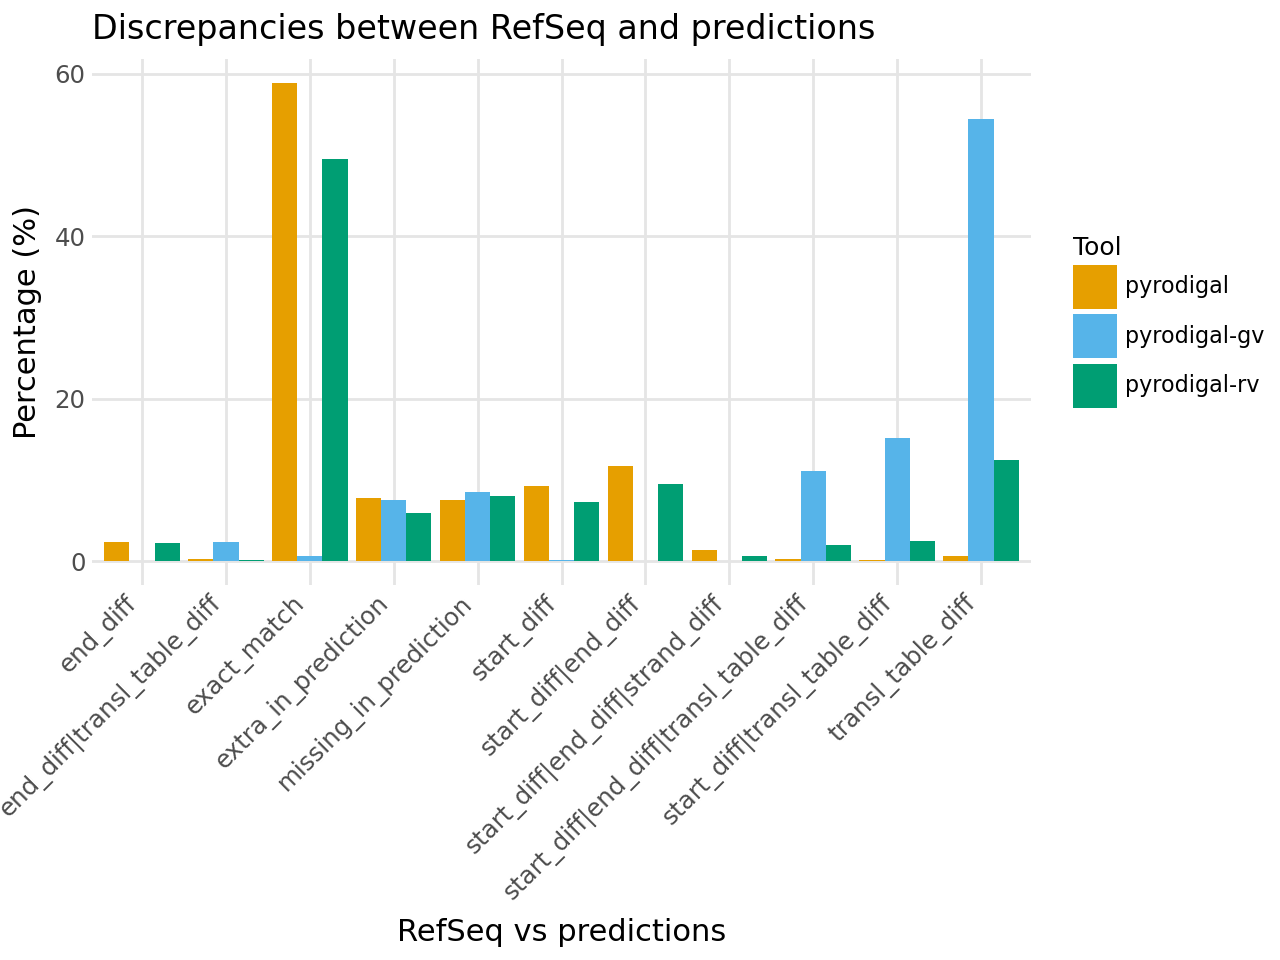

/lustre1/project/stg_00029/LDC/software/miniforge3-genius/envs/gb_submitter/lib/python3.12/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 6.4 x 4.8 in image.
/lustre1/project/stg_00029/LDC/software/miniforge3-genius/envs/gb_submitter/lib/python3.12/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: refseq_genomes/comparison.png


In [8]:
import polars as pl
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal, theme, element_text, scale_y_continuous, scale_fill_manual, element_blank

# Read the TSV file
df = pl.read_csv('refseq_genomes/comparison_results_all.tsv', separator='\t', null_values=['NA'])
df = df.unique()

# Calculate status counts and percentages per source
status_counts = (
    df.group_by(['source', 'status'])
    .agg(pl.len().alias('count'))
    .with_columns(
        (pl.col('count') / pl.col('count').sum().over('source') * 100).alias('percentage')
    )
    .with_columns(
        pl.col('source').replace({
            'vanilla_predictions_closed': 'pyrodigal',
            'gv_predictions_closed': 'pyrodigal-gv',
            'predictions_closed': 'pyrodigal-rv'
        })
    )
)
with pl.Config(
        tbl_rows=-1,  # Display all rows
        fmt_str_lengths=1000,  # Max length of string representation in columns
        tbl_width_chars=1000,  # Max total width of the table in characters
        tbl_hide_dataframe_shape=True # Hide the 'shape: (rows, columns)' line
    ):
        # Sum percentages for statuses containing start_diff or end_diff
    position_diff_summary = (
        status_counts
        .filter(
            pl.col('status').str.contains('start_diff') | 
            pl.col('status').str.contains('end_diff')
        )
        .group_by('source')
        .agg(
            pl.col('percentage').sum().alias('position_diff_percentage')
        )
    )

    print(position_diff_summary)
    print(status_counts)



# Define a colorblind-friendly palette
colors = [
    '#E69F00',  # Orange
    '#56B4E9',  # Sky Blue
    '#009E73',  # Bluish Green
    '#F0E442',  # Yellow
    '#0072B2',  # Blue
    '#D55E00',  # Vermillion
    '#CC79A7',  # Reddish Purple
    '#999999',  # Gray
    '#000000'   # Black
]

# Create the bar chart
plot = (
    ggplot(status_counts, aes(x='status', y='percentage', fill='source')) +
    geom_bar(stat='identity', position='dodge') +
    scale_fill_manual(values=colors) +
    labs(
        title='Discrepancies between RefSeq and predictions',
        y='Percentage (%)',
        fill='Tool',
        x='RefSeq vs predictions'
    ) +
    #scale_y_continuous(limits=(0, 100)) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=12, hjust=0),
        axis_text_x=element_text(angle=45, hjust=1),
        legend_position='right',
        legend_text=element_text(size=8),
        legend_title=element_text(size=9),
        panel_grid_minor=element_blank()
    )
)

# Display the plot
plot.show()

plot.save('refseq_genomes/comparison.png', dpi=300)

In [9]:
# Count missing_in_predictions, extra_predictions, and total predictions (excluding missing) for each source
counts = (
    df.group_by('source')
    .agg([
        pl.col('status').filter(pl.col('status') == 'missing_in_prediction').len().alias('missing_in_predictions'),
        pl.col('status').filter(pl.col('status') == 'extra_in_prediction').len().alias('extra_in_predictions'),
        pl.col('status').filter(pl.col('status') != 'missing_in_prediction').len().alias('total_predictions')
    ])
)

print(counts)

shape: (3, 4)
┌────────────────────────────┬────────────────────────┬──────────────────────┬───────────────────┐
│ source                     ┆ missing_in_predictions ┆ extra_in_predictions ┆ total_predictions │
│ ---                        ┆ ---                    ┆ ---                  ┆ ---               │
│ str                        ┆ u32                    ┆ u32                  ┆ u32               │
╞════════════════════════════╪════════════════════════╪══════════════════════╪═══════════════════╡
│ vanilla_predictions_closed ┆ 1692                   ┆ 1744                 ┆ 20935             │
│ gv_predictions_closed      ┆ 1918                   ┆ 1711                 ┆ 20676             │
│ predictions_closed         ┆ 1768                   ┆ 1311                 ┆ 20426             │
└────────────────────────────┴────────────────────────┴──────────────────────┴───────────────────┘


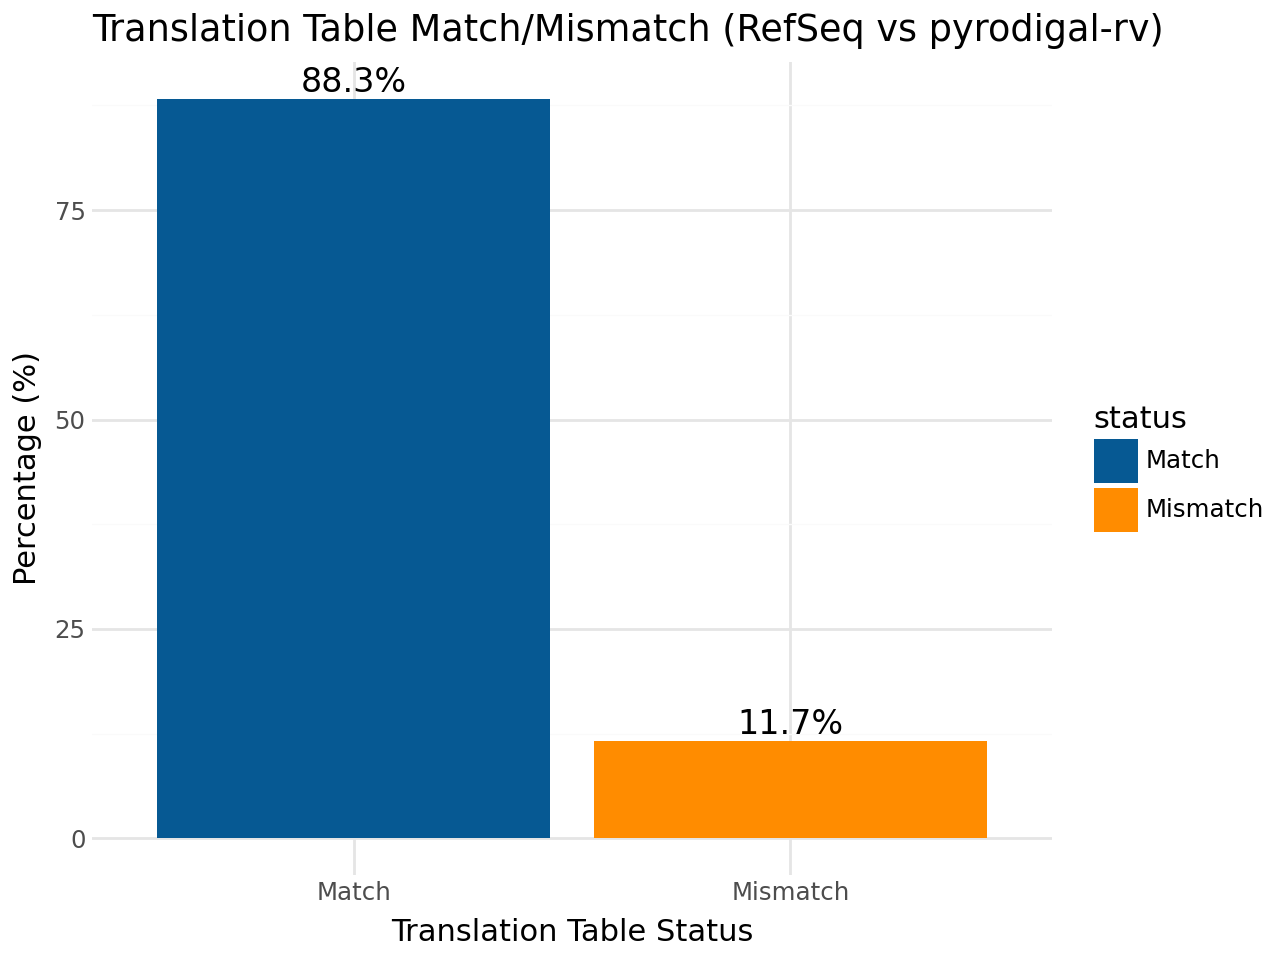

/lustre1/project/stg_00029/LDC/software/miniforge3-genius/envs/gb_submitter/lib/python3.12/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 6.4 x 4.8 in image.
/lustre1/project/stg_00029/LDC/software/miniforge3-genius/envs/gb_submitter/lib/python3.12/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: refseq_genomes/transl_table_mismatch.png


In [10]:
import polars as pl
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal, geom_text

# Read the TSV file
df = pl.read_csv('refseq_genomes/comparison_results_all.tsv', separator='\t', null_values=['NA'])
df = df.unique()

df = df.filter(pl.col('source') == 'predictions_closed')

# Select relevant columns and get unique rows per sequence
unique_seqs = df.select(['seqid', 'gt_transl_table', 'pred_transl_table']).unique()

# Calculate match/mismatch counts
mismatch_summary = (
    unique_seqs.with_columns(
        pl.when(pl.col('gt_transl_table') != pl.col('pred_transl_table'))
        .then(pl.lit('Mismatch'))
        .otherwise(pl.lit('Match'))
        .alias('status')
    )
    .group_by('status')
    .agg(pl.len().alias('count'))
    .with_columns(
        (pl.col('count') / pl.col('count').sum() * 100).alias('percentage')
    )
)

# Define a colorblind-friendly palette
colors = [
    '#065993',
    'darkorange',  # Orange
]

# Create the bar chart
tt = (
    ggplot(mismatch_summary, aes(x='status', y='percentage', fill='status')) +
    geom_bar(stat='identity') +
    geom_text(aes(label='percentage'), 
              format_string='{:.1f}%', 
              va='bottom', 
              size=12) +
    scale_fill_manual(values=colors) +
    labs(
        title='Translation Table Match/Mismatch (RefSeq vs pyrodigal-rv)',
        x='Translation Table Status',
        y='Percentage (%)'
    ) +
    theme_minimal()+
    theme(plot_title=element_text(hjust=0))
)

tt.show()

tt.save('refseq_genomes/transl_table_mismatch.png', dpi=300)
# Optional: print the actual numbers
#print(mismatch_summary)

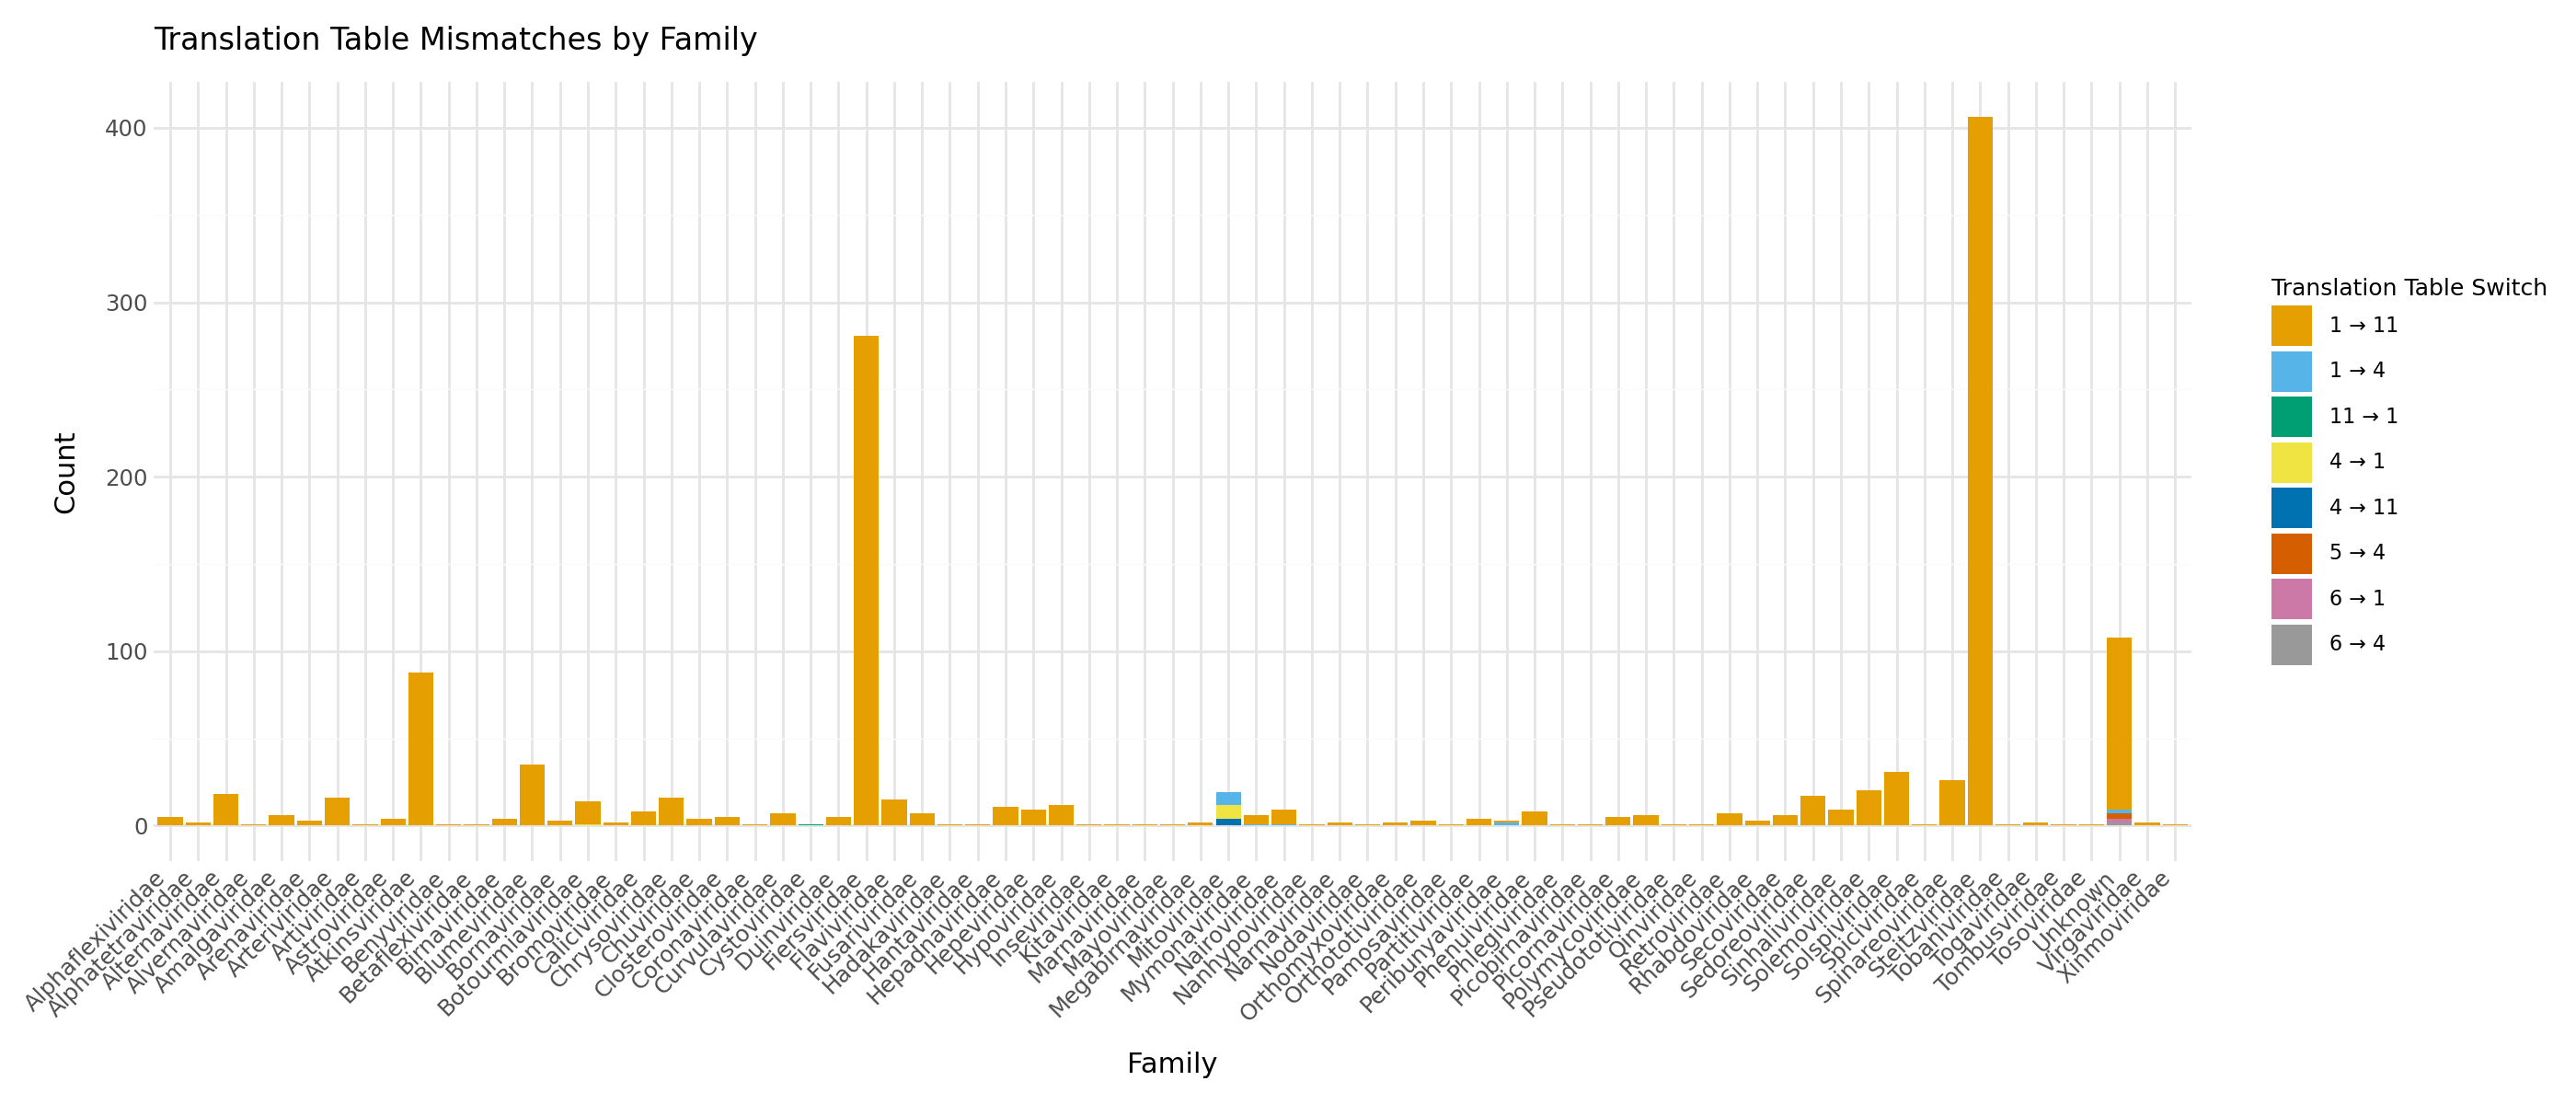

/lustre1/project/stg_00029/LDC/software/miniforge3-genius/envs/gb_submitter/lib/python3.12/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 14 x 6 in image.
/lustre1/project/stg_00029/LDC/software/miniforge3-genius/envs/gb_submitter/lib/python3.12/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: refseq_genomes/transl_table_mismatches_by_family.png


In [11]:
import polars as pl
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal, theme, element_text

# Read the TSV file
df = pl.read_csv('transl_table_mismatches_taxonomy_predictions_closed.tsv', separator='\t', null_values=['NA'])

# Count mismatches per family and mismatch pattern
mismatch_counts = (
    df.group_by(['family', 'mismatch_pattern'])
    .agg(pl.len().alias('count'))
    #.with_columns(
    #    (pl.col('count') / pl.col('count').sum() * 100).alias('percentage')
    #)
)

# Define a colorblind-friendly palette
colors = [
    '#E69F00',  # Orange
    '#56B4E9',  # Sky Blue
    '#009E73',  # Bluish Green
    '#F0E442',  # Yellow
    '#0072B2',  # Blue
    '#D55E00',  # Vermillion
    '#CC79A7',  # Reddish Purple
    '#999999',  # Gray
    '#000000'   # Black
]

# Create the bar chart
tt_fam = (
    ggplot(mismatch_counts, aes(x='family', y='count', fill='mismatch_pattern')) +
    geom_bar(stat='identity') +
    labs(
        title='Translation Table Mismatches by Family',
        x='Family',
        y='Count',
        fill='Translation Table Switch'
    ) +
    scale_fill_manual(values=colors) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=12, hjust=0),
        axis_text_x=element_text(angle=45, hjust=1),
        legend_text=element_text(size=8),
        legend_title=element_text(size=9),
        figure_size=(14, 6)  # width=14, height=6
    )
)

tt_fam.show()
tt_fam.save('refseq_genomes/transl_table_mismatches_by_family.png', dpi=300)

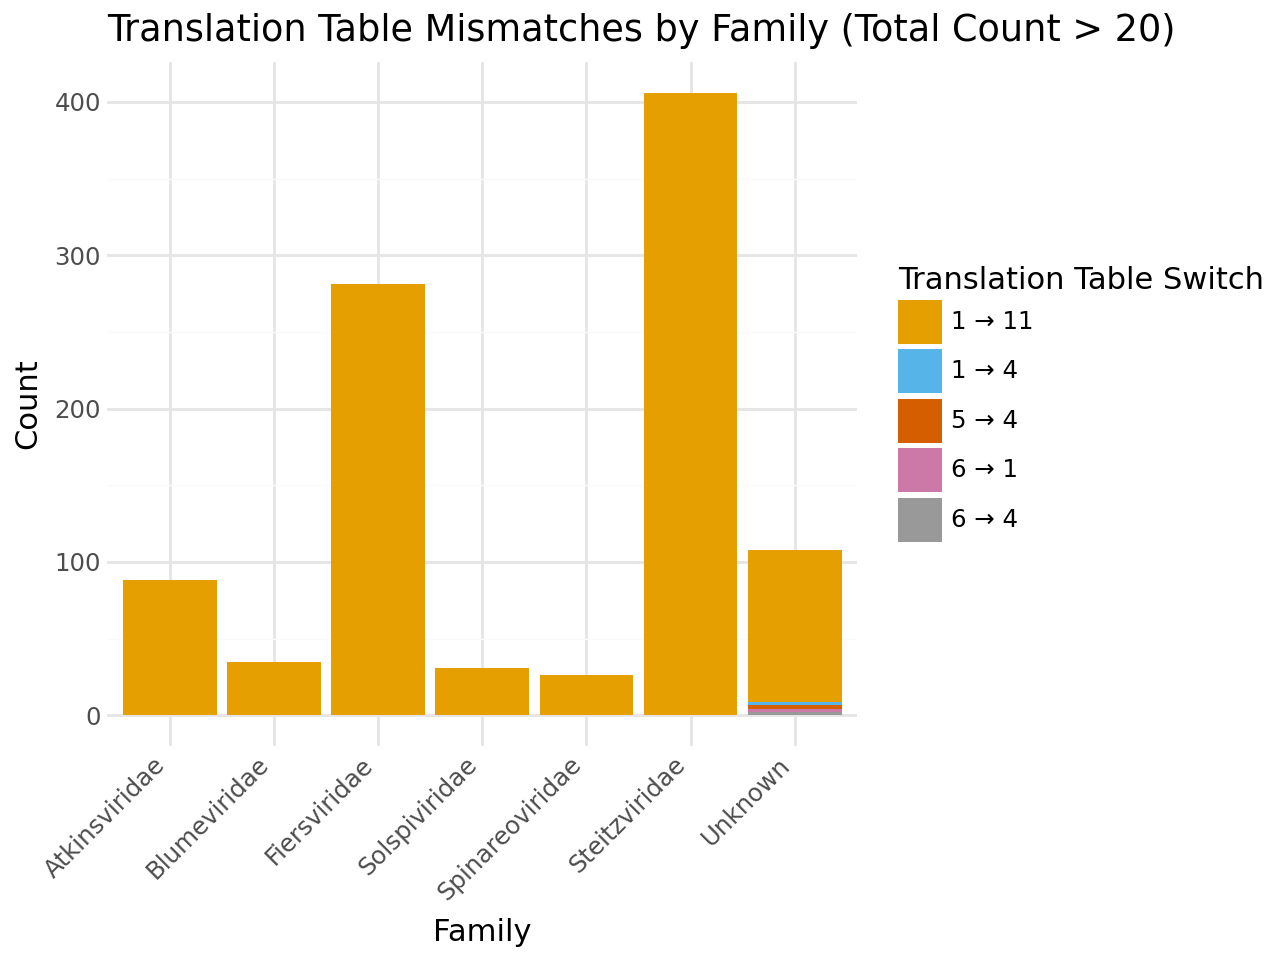

In [12]:
import polars as pl
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal, theme, element_text

# Read the TSV file
df = pl.read_csv('transl_table_mismatches_taxonomy_predictions_closed.tsv', separator='\t', null_values=['NA'])

# Calculate total count per family
family_totals = (
    df.group_by('family')
    .agg(pl.len().alias('total_count'))
    .filter(pl.col('total_count') > 20)
)

# Get detailed counts for families with total > 20
mismatch_counts = (
    df.group_by(['family', 'mismatch_pattern'])
    .agg(pl.len().alias('count'))
    .join(family_totals.select('family'), on='family', how='inner')
)

colors = [
    '#E69F00',  # Orange
    '#56B4E9',  # Sky Blue
    #'#009E73',  # Bluish Green
    #'#F0E442',  # Yellow
    #'#0072B2',  # Blue
    '#D55E00',  # Vermillion
    '#CC79A7',  # Reddish Purple
    '#999999',  # Gray
    '#000000'   # Black
]

# Create the bar chart
plot = (
    ggplot(mismatch_counts, aes(x='family', y='count', fill='mismatch_pattern')) +
    geom_bar(stat='identity') +
    labs(
        title='Translation Table Mismatches by Family (Total Count > 20)',
        x='Family',
        y='Count',
        fill='Translation Table Switch'
    ) +
    scale_fill_manual(values=colors) +
    theme_minimal() +
    theme(axis_text_x=element_text(angle=45, hjust=1),
          plot_title=element_text(hjust=0))
)

plot